#Notebook 2: Modelado de datos.

En la primera parte de este Notebook se implementará un modelo de árboles de decisión para resolver el problema propuesto en el enunciado con los datos previamente procesados. En la segunda parte se evaluará el rendimiento del modelo con diferentes métricas cuantitativas y cualitativas con el objetivo de saber si se puede aplicar efectivamente a este caso.

##2. Creación del modelo.

###2.1. Importación de librerias y carga de datos.


In [17]:
# Instalación de librerias
import pandas as pd
import numpy as np
from collections import Counter
import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install langdetect
from langdetect import detect
from nltk.stem import SnowballStemmer
#from pandas_profiling import ProfileReport
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SpanishStemmer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

In [18]:
ODS_df_train = pd.read_csv('data/ods_limpios.csv', sep=',', encoding = 'UTF-8')
ODS_df_train.shape
ODS_df_train = ODS_df_train.drop(['Unnamed: 0'], axis=1)
ODS_df_train.head()

,sdg,000,001,003,004,005,006,007,008,009,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
ODS_df_train.isna().sum()

,0
sdg,0
000,102
001,102
003,102
004,102
...,...
zonmw,102
zuck,102
zukowski,102
zupanc,102


###2.2. Modelado de Datos: Arbol de decisión.

Busqueda de hiperparametros.

In [7]:
Y=ODS_df_train['sdg']
X=ODS_df_train.drop(['sdg'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy','log_loss'],'max_depth':[2,3,4,5,6,8,10,20,40]}
arbol = DecisionTreeClassifier(random_state=0)
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
mejor_modelo.fit(X_train, Y_train)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 8}

In [8]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 8, random_state = 0)
arbol

DecisionTreeClassifier(max_depth=8, random_state=0)

In [9]:
arbol = arbol.fit(X_train,Y_train)

In [10]:
y_pred = arbol.predict(X_test)

###3. Resultados

In [11]:
cm = confusion_matrix(Y_test, y_pred)

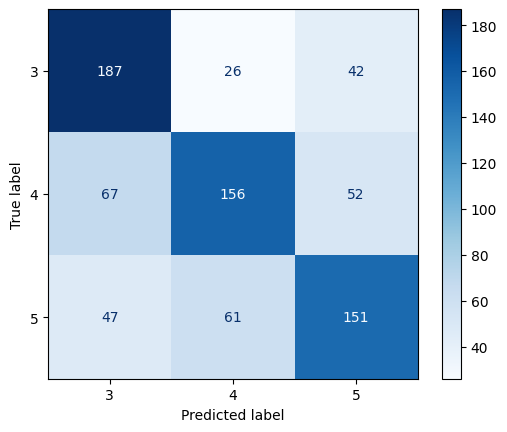

In [12]:
#plot_confusion_matrix(arbol, X_test, Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [13]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred, average="macro")))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average="macro")))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average="macro")))

Exactitud: 0.63
Recall: 0.6278725478725479
Precisión: 0.626521432575327
Puntuación F1: 0.6247282740088496


In [14]:
peso = arbol.feature_importances_

peso_columna = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": peso})
peso_columna = peso_columna.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
peso_columna

,Atributo,Importancia
0,mujer,0.088802
1,salud,0.048014
2,educ,0.041865
3,escuel,0.009266
4,gener,0.007434
...,...,...
11404,examen,NaN
11405,frent,NaN
11406,identif,NaN
11407,junt,NaN


In [15]:
arbol_final = mejor_modelo.best_estimator_

y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.66
Exactitud sobre test: 0.63


In [16]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           3       0.62      0.73      0.67       255
           4       0.64      0.57      0.60       275
           5       0.62      0.58      0.60       259

    accuracy                           0.63       789
   macro avg       0.63      0.63      0.62       789
weighted avg       0.63      0.63      0.62       789

